In [31]:
import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np 
from IPython.display import HTML

In [32]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [33]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    batch_size= BATCH_SIZE,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
   
)

Found 25802 files belonging to 16 classes.


In [34]:
print(f"Found {tf.data.experimental.cardinality(dataset).numpy() * BATCH_SIZE} files belonging to {len(dataset.class_names)} classes.")

Found 25824 files belonging to 16 classes.


In [35]:
class_names = dataset.class_names
print("Class Names:", class_names)

Class Names: ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [36]:
class_names = dataset.class_names
print(class_names)

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [37]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

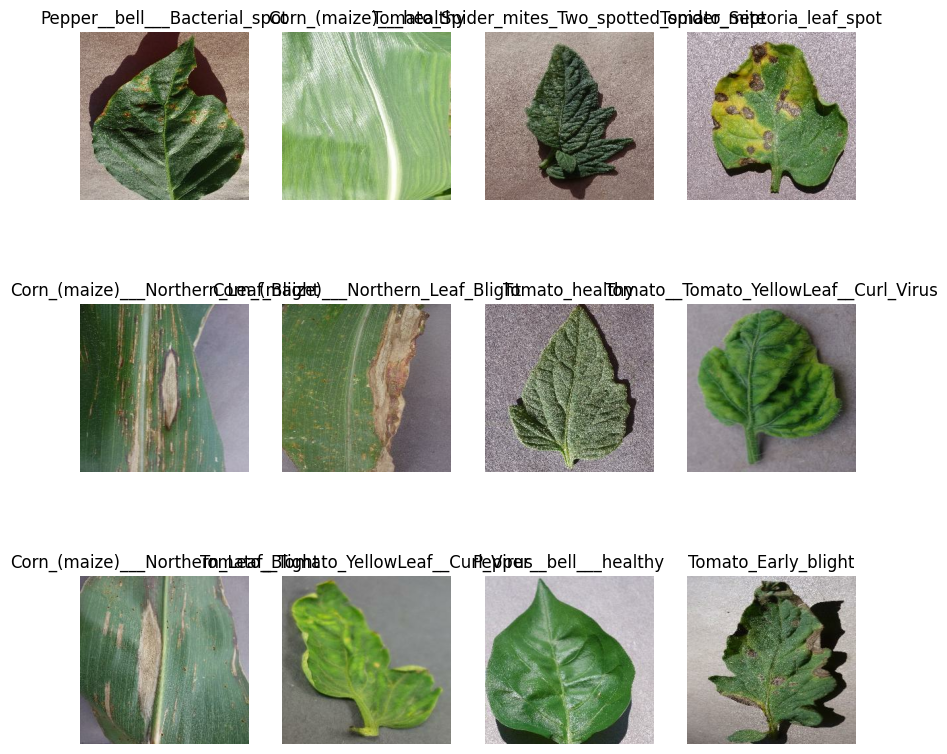

In [38]:
plt.figure(figsize= (10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):   
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [39]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [40]:
# Apply the splitting function
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [41]:
print(f"Number of training batches: {len(train_ds)}")
print(f"Number of validation batches: {len(val_ds)}")
print(f"Number of test batches: {len(test_ds)}")

Number of training batches: 645
Number of validation batches: 80
Number of test batches: 82


In [42]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
# Creating a Layer for Resizing and Normalization
# This layer ensures all images are resized to IMAGE_SIZE x IMAGE_SIZE and pixel values are scaled to 0-1.
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), # Changed from layers.experimental.preprocessing.Resizing
  layers.Rescaling(1./255)
])

In [44]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"), # Randomly flips images horizontally or vertically
  layers.RandomRotation(0.2), # Randomly rotates images by up to 20%
])

In [45]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names) # Dynamically set the number of output classes


In [46]:
model = models.Sequential([
    resize_and_rescale, # First, resize and rescale the input images

    # Optional: If you want data augmentation to be part of the model's graph
    # and applied during inference (which is usually NOT what you want for production),
    # you could include data_augmentation here:
    # data_augmentation,

    # Convolutional layers with MaxPooling for feature extraction
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(), # Flatten the 3D output of the convolutional layers into a 1D vector
    layers.Dense(64, activation='relu'), # A densely connected (fully connected) layer
    layers.Dense(n_classes, activation='softmax'), # Output layer with n_classes neurons and softmax for classification
])


model.summary() 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # from_logits=False because we use softmax activation
    metrics=['accuracy']
)

In [19]:
checkpoint_dir = "C:/projects/final_year_project/model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok = True)

In [20]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model_val_acc_{val_accuracy:.4f}_epoch_{epoch:02d}.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

In [21]:
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [22]:
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

In [23]:
csv_logger_callback = CSVLogger(os.path.join(checkpoint_dir, 'training_log.csv'), append=True)

In [24]:
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    model.load_weights(latest_checkpoint)
    initial_epoch = int(latest_checkpoint.split('_epoch_')[1].split('.')[0])
    print(f"Resuming training from epoch {initial_epoch}")
else:
    initial_epoch = 0
    print("Starting training from scratch")

Starting training from scratch


In [25]:
print("\nStarting optimized model training...")
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    initial_epoch=initial_epoch,
    callbacks=[
        model_checkpoint_callback,
        early_stopping_callback,
        reduce_lr_callback,
        csv_logger_callback
    ]
)
print("Model training finished.")


Starting optimized model training...
Epoch 1/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3074 - loss: 2.1177
Epoch 1: val_accuracy improved from -inf to 0.54961, saving model to C:/projects/final_year_project/model_checkpoints\best_model_val_acc_0.5496_epoch_01.keras
645/645 ━━━━━━━━━━━━━━━━━━━━ 1031s 1s/step - accuracy: 0.3076 - loss: 2.1169 - val_accuracy: 0.5496 - val_loss: 1.4801 - learning_rate: 0.0010
Epoch 2/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7098 - loss: 0.8390
Epoch 2: val_accuracy improved from 0.54961 to 0.61133, saving model to C:/projects/final_year_project/model_checkpoints\best_model_val_acc_0.6113_epoch_02.keras
645/645 ━━━━━━━━━━━━━━━━━━━━ 725s 1s/step - accuracy: 0.7099 - loss: 0.8389 - val_accuracy: 0.6113 - val_loss: 1.2452 - learning_rate: 0.0010
Epoch 3/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.7792 - loss: 0.6324
Epoch 3: val_accuracy improved from 0.61133 to 0.70508, saving model to C:/projects/final_year_pro

In [48]:
# Load the best saved model
checkpoint_dir = "C:/projects/final_year_project/model_checkpoints"
if os.path.exists(checkpoint_dir) and os.listdir(checkpoint_dir):
    try:
        best_checkpoint = max([f for f in os.listdir(checkpoint_dir) if f.endswith('.keras')], 
                             key=lambda x: float(x.split('val_acc')[1].split('_')[0]))
        model = tf.keras.models.load_model(os.path.join(checkpoint_dir, best_checkpoint))
        print(f"Loaded best model from: {os.path.join(checkpoint_dir, best_checkpoint)}")
        model.summary()
    except (ValueError, IndexError) as e:
        print(f"Error parsing checkpoint filenames: {e}. Please check file naming convention.")
    except FileNotFoundError:
     print(f"Checkpoint directory {checkpoint_dir} not found.")
    else:
     print("No checkpoints found in the directory.")

Error parsing checkpoint filenames: could not convert string to float: ''. Please check file naming convention.


In [49]:
import os
checkpoint_dir = "C:/projects/final_year_project/model_checkpoints"
if os.path.exists(checkpoint_dir):
    print("Directory exists. Contents:", os.listdir(checkpoint_dir))
else:
    print(f"Directory {checkpoint_dir} does not exist.")

Directory exists. Contents: ['best_model_val_acc_0.5496_epoch_01.keras', 'best_model_val_acc_0.6113_epoch_02.keras', 'best_model_val_acc_0.7051_epoch_03.keras', 'best_model_val_acc_0.7445_epoch_04.keras', 'best_model_val_acc_0.8730_epoch_05.keras', 'best_model_val_acc_0.8758_epoch_08.keras', 'best_model_val_acc_0.9062_epoch_10.keras', 'best_model_val_acc_0.9367_epoch_15.keras', 'best_model_val_acc_0.9406_epoch_18.keras', 'best_model_val_acc_0.9469_epoch_20.keras', 'best_model_val_acc_0.9531_epoch_25.keras', 'best_model_val_acc_0.9543_epoch_26.keras', 'best_model_val_acc_0.9637_epoch_32.keras', 'best_model_val_acc_0.9723_epoch_33.keras', 'best_model_val_acc_0.9770_epoch_34.keras', 'best_model_val_acc_0.9777_epoch_36.keras', 'best_model_val_acc_0.9836_epoch_42.keras', 'training_log.csv']


In [53]:
checkpoint_dir = "C:/projects/final_year_project/model_checkpoints"

best_checkpoint = max(
    [f for f in os.listdir(checkpoint_dir) if f.endswith('.keras')],
    key=lambda x: float(x.split('val_acc_')[1].split('_')[0])
)

model = tf.keras.models.load_model(os.path.join(checkpoint_dir, best_checkpoint))
print(f"Loaded best model from: {os.path.join(checkpoint_dir, best_checkpoint)}")
model.summary()

Loaded best model from: C:/projects/final_year_project/model_checkpoints\best_model_val_acc_0.9836_epoch_42.keras


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           1,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 553,778 (2.11 MB)

 Trainable params: 184,592 (721.06 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 369,186 (1.41 MB)

In [54]:
print("\nEvaluating model on test dataset...")
scores = model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]*100:.2f}%")


Evaluating model on test dataset...
82/82 ━━━━━━━━━━━━━━━━━━━━ 61s 345ms/step - accuracy: 0.9857 - loss: 0.0376
Test Loss: 0.0502
Test Accuracy: 98.13%


In [57]:
# --- 12. Plotting the Accuracy and Loss Curves ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


NameError: name 'history' is not defined

In [58]:
def predict(model, img_array_single_image):
    # Expand dimensions to simulate a batch of 1 image
    img_array_expanded = tf.expand_dims(img_array_single_image, 0)

    predictions = model.predict(img_array_expanded)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


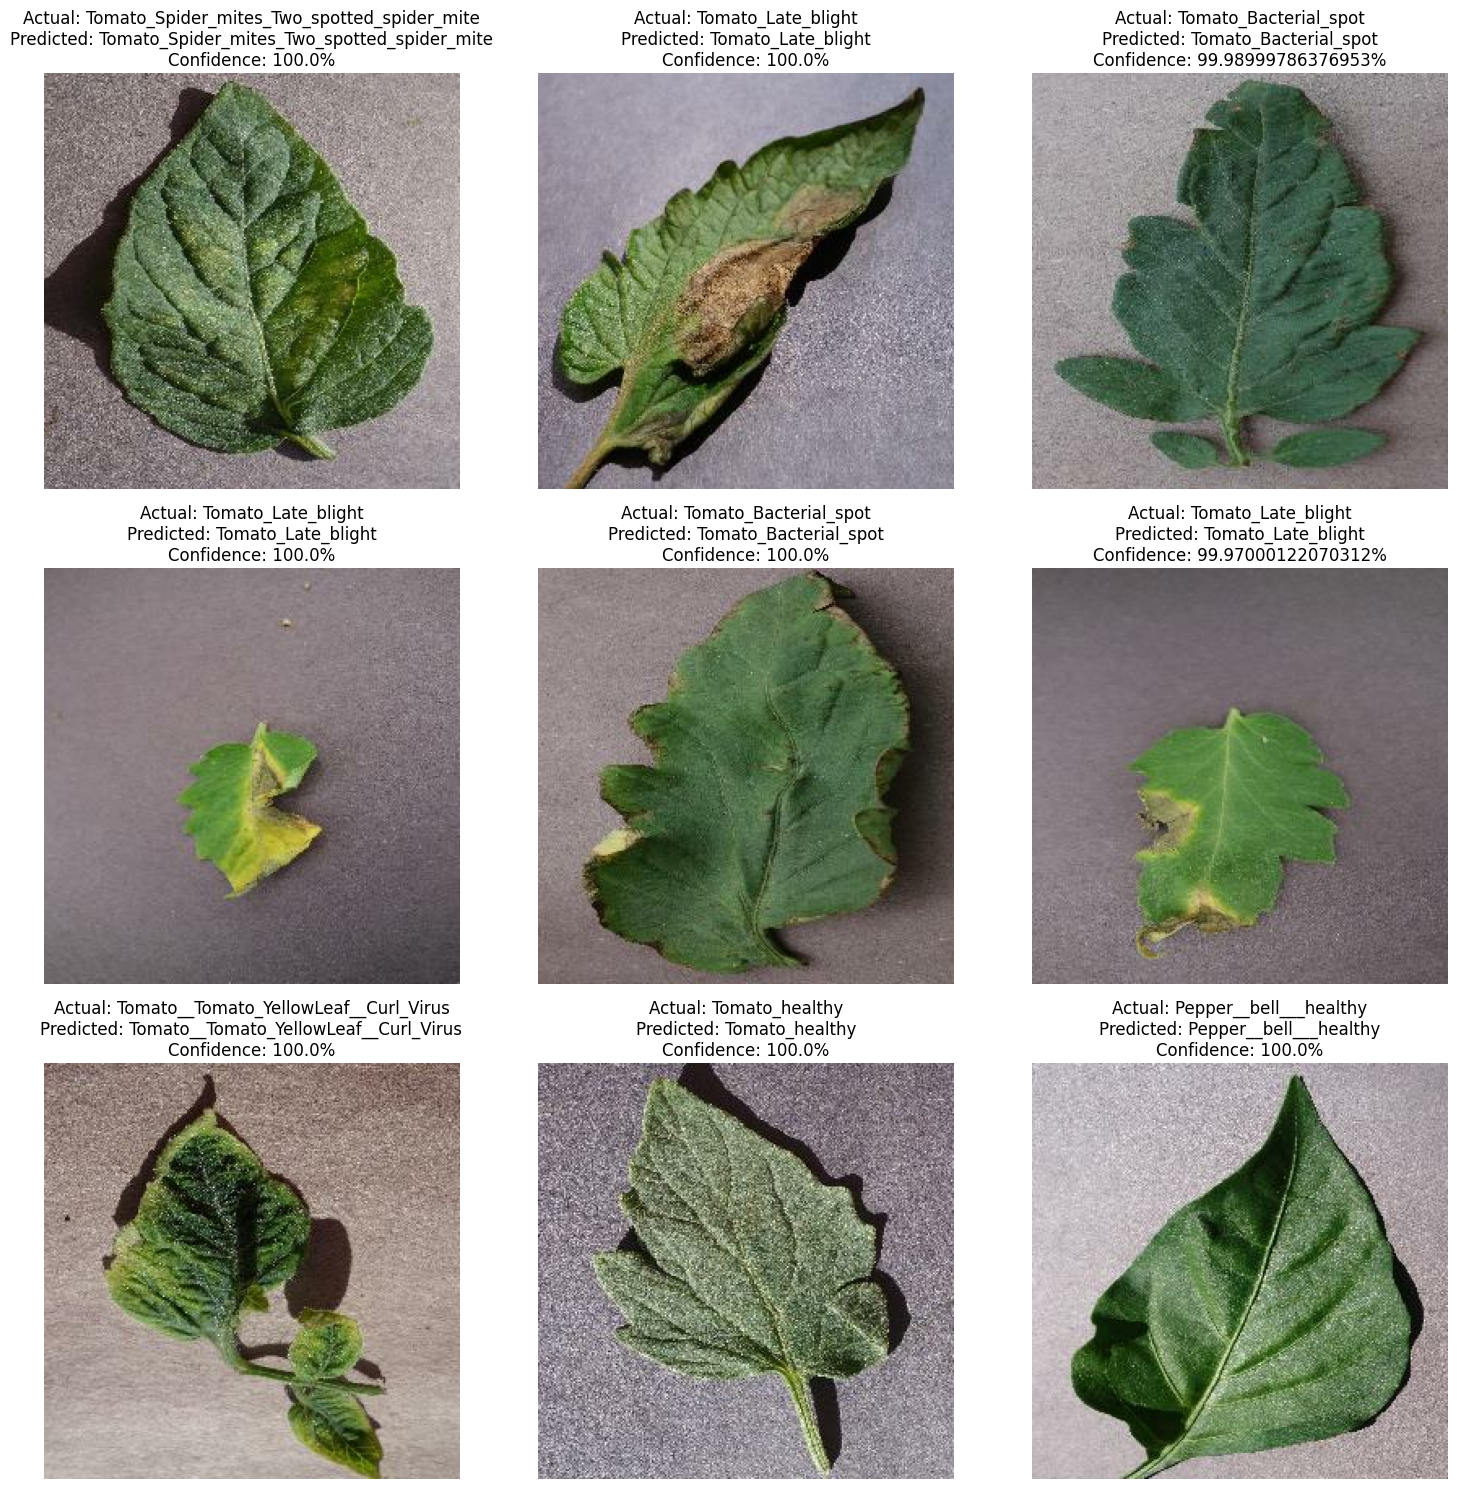

In [72]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):  # Take one batch from the test dataset
    for i in range(min(9, BATCH_SIZE)):  # Iterate through first 9 images (or fewer if batch_size is smaller)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Predict for the current image
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")
plt.tight_layout()
plt.show()

In [61]:

import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file saved by CSVLogger
csv_path = "C:/projects/final_year_project/model_checkpoints/training_log.csv"
history_df = pd.read_csv(csv_path)


In [62]:
acc = history_df['accuracy']
val_acc = history_df['val_accuracy']
loss = history_df['loss']
val_loss = history_df['val_loss']


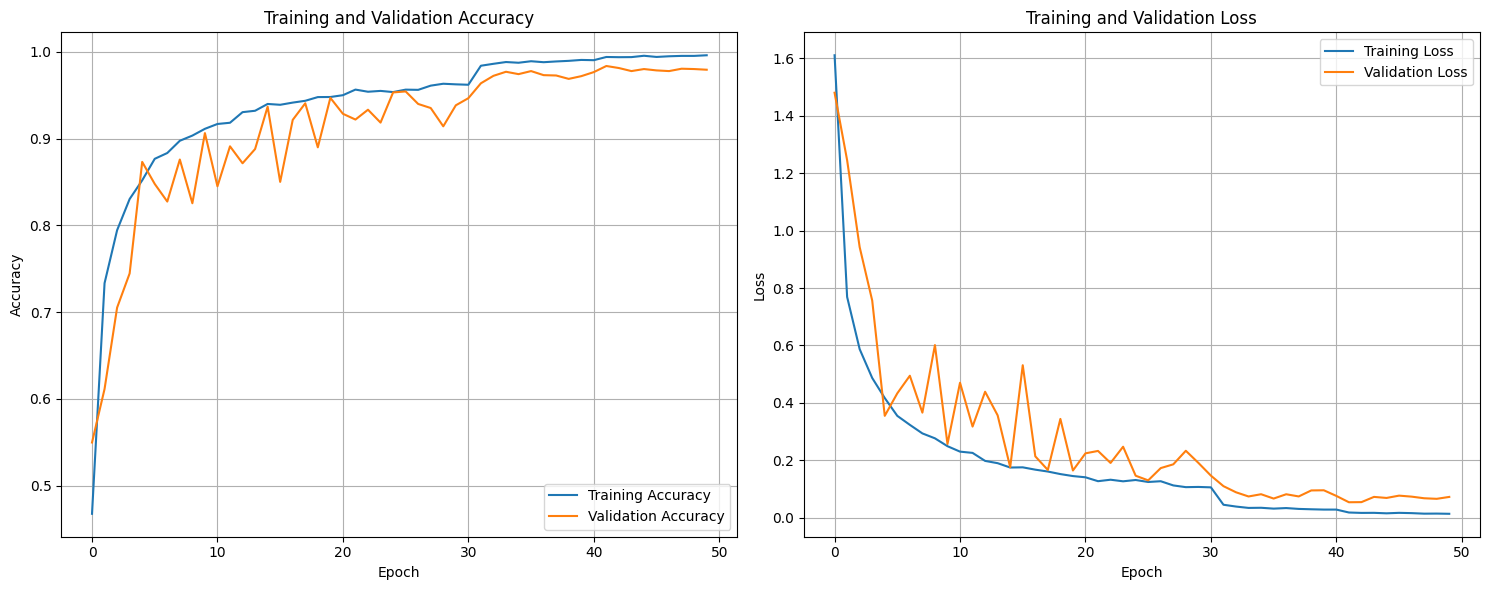

In [63]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [66]:
models_dir = "C:/Users/NANA EKOW BRYAN/fyp"  
os.makedirs(models_dir, exist_ok=True) 

In [67]:
try:
    existing_versions = [int(i) for i in os.listdir(models_dir) if i.isdigit()]
    model_version = max(existing_versions) + 1 if existing_versions else 1
except FileNotFoundError:  # If the directory doesn't exist yet
    model_version = 1
except Exception as e:
    print(f"Error determining model version, defaulting to 1: {e}")
    model_version = 1


In [69]:
model_save_path_tf = os.path.join(models_dir, str(model_version))
model.export(model_save_path_tf)


INFO:tensorflow:Assets written to: C:/Users/NANA EKOW BRYAN/fyp\1\assets


INFO:tensorflow:Assets written to: C:/Users/NANA EKOW BRYAN/fyp\1\assets


Saved artifact at 'C:/Users/NANA EKOW BRYAN/fyp\1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)
Captures:
  3005426558128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3005426563056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3005426790496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3005426787856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3005426786800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3005426880880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3005426887744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3005426884752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3005426892496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3005426891792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3005427149536: Ten

In [70]:
model_save_path_tf = os.path.join(models_dir, f"{model_version}.keras")
model.save(model_save_path_tf)
